In [1]:
# import hdf5plugin, h5py
import torch, tables
from torch import nn
import os
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
from dataclasses import dataclass
from typing import Callable
import cv2, functools

import torch.nn

# Monkey patch pytables to make thread safe
# https://www.pytables.org/cookbook/threading.html#monkey-patching-pytables
import threading

import tables as tb
import tables.file as _tables_file

class ThreadsafeFileRegistry(_tables_file._FileRegistry):
    lock = threading.RLock()

    @property
    def handlers(self):
        return self._handlers.copy()

    def add(self, handler):
        with self.lock:
            return super().add(handler)

    def remove(self, handler):
        with self.lock:
            return super().remove(handler)

    def close_all(self):
        with self.lock:
            return super().close_all(handler)

class ThreadsafeFile(_tables_file.File):
    def __init__(self, *args, **kargs):
        with ThreadsafeFileRegistry.lock:
            super().__init__(*args, **kargs)

    def close(self):
        with ThreadsafeFileRegistry.lock:
            super().close()

@functools.wraps(tb.open_file)
def synchronized_open_file(*args, **kwargs):
    with ThreadsafeFileRegistry.lock:
        return _tables_file._original_open_file(*args, **kwargs)

# monkey patch the tables package
_tables_file._original_open_file = _tables_file.open_file
_tables_file.open_file = synchronized_open_file
tb.open_file = synchronized_open_file

_tables_file._original_File = _tables_file.File
_tables_file.File = ThreadsafeFile
tb.File = ThreadsafeFile

_tables_file._open_files = ThreadsafeFileRegistry()

In [2]:
directory = "/data/uw/200807_ffhq/"
# f = "R1_E2_AMES_300min_ffhq_6250_10000.h5" # busted
f = "R1_E1_AMES_160min_ffhq_0_2501.h5" # fine!
# f = "R1_E3_AMES_430min_ffhq_generated_2500_4999" # busted
# f = "R1_E4_AMES_640min_ffhq_0_5000" # fine!
# f = "R1_E4_AMES_640min_ffhq_0_5000.h5" # fine!

hdf5 = tables.open_file(os.path.join(directory,f),'r')
h5 = hdf5.root
# h5 = h5py.File(os.path.join(directory,f),'r', swmr=True)

In [3]:
h5["data"][:10].sum()

117195

In [4]:
nExamples, nTime, nRow, nCol, nUnitChannels = h5["data"].shape
h5

/ (RootGroup) ''
  children := ['data' (CArray), 'image_classes' (CArray), 'images' (CArray), 'target' (CArray)]

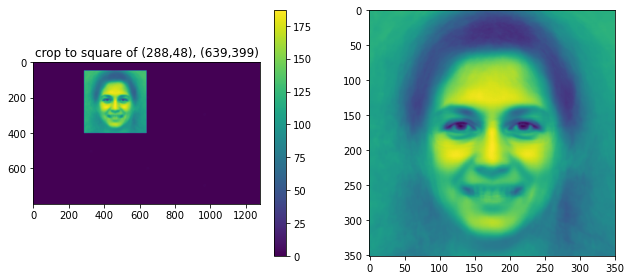

In [5]:
imgs = h5["images"][0:100]

avg_img = np.mean(imgs, axis=(0,3))

y,x = np.where(avg_img>5)

xleft = min(x)
xright = max(x)
ytop = min(y)
ybot = max(y)

plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(avg_img)
plt.colorbar()
plt.title(f"crop to square of ({xleft},{ytop}), ({xright},{ybot})")
plt.subplot(122)
plt.imshow(avg_img[ytop:ybot,xleft:xright])
plt.tight_layout()

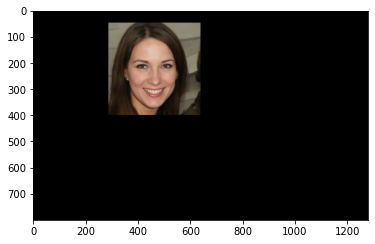

In [6]:
# should see image
plt.imshow(h5["images"][-1])

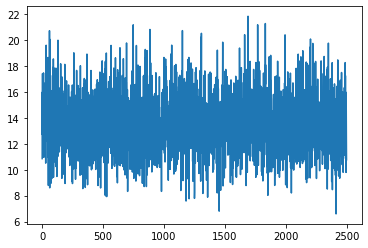

In [7]:
# all frames should have similar mean of 10-20
imgs = h5["images"][()]
avg = np.mean(imgs,axis=(1,2,3))
plt.plot(avg)

In [8]:
# need to open in each process
# h5.close()

def resize_3d(images, fx, fy, interpolation=cv2.INTER_LINEAR, out="ndarray",
        is_tiff=False):
    im = cv2.resize((images[0]), None, fx=fx, fy=fy, interpolation=interpolation)
    if out=="ndarray":
        new = np.zeros([images.shape[0], *im.shape],
            dtype = np.float32)
    elif out=="memmap":
        new = np.memmap("glia_temp_memmap.mmap", np.float32, "w+",
            (images.shape[0], im.shape[0],im.shape[1]))
    for z, img in enumerate(images):
        new[z] = cv2.resize((img), None, fx=fx, fy=fy,
            interpolation=interpolation)
    return new

def gray_3d(images):
    im = cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)
    new = np.zeros([images.shape[0], *im.shape],
            dtype = np.float32)
    for z, img in enumerate(images):
        new[z] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return new



@dataclass
class ImageData(Dataset):
    original_images:tables.carray.CArray
#     h5_path:str
#     dset_path:str = "images"
    H:int = 64 # resize to this
    W:int = 64
    convert_to_gray:bool = True
    interpolation:Callable = cv2.INTER_LINEAR
        
    def __post_init__(self):
#         self.h5 = h5py.File(h5_path,'r')
#         self.h5 = tables.open_file(h5_path,'r').root
#         self.original_images = self.h5[self.dset_path]
        oH, oW = self.original_images.shape[1:3]
        self.images = resize_3d(self.original_images,
            fx=self.W/oW, fy=self.H/oH, interpolation=self.interpolation)
        if self.convert_to_gray:
            self.images = gray_3d(self.images)[...,None]
        # H x W x C -> C x H x W
#     def __del__(self):
#         self.h5.close()
        
    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, i):
        im = transforms.functional.to_tensor(self.images[i])
        if self.convert_to_gray:
            im = transforms.functional.normalize(im,(0.5,),(1.0,))
        else:
            im = transforms.functional.normalize(im,(0.5,0.5,0.5),(1.0,1.0,1.0))
        return im
    
@dataclass
class RetinaData(Dataset):
    # we use HDF5 for compression of sparse data
    # otherwise, RAM would blow up
    retina_data:tables.carray.CArray
#     h5_path:str
#     dset_path:str = "data"
    nbins:int = 10
    def __post_init__(self):
#         self.h5 = h5py.File(h5_path,'r')
#         self.h5 = tables.open_file(h5_path,'r').root
#         self.retina_data = self.h5[self.dset_path]
        self.slices = np.linspace(0, self.retina_data.shape[1], self.nbins+1, True).astype(np.int)
    def __len__(self):
        return self.retina_data.shape[0]
    def __getitem__(self,i):
        binned = np.add.reduceat(self.retina_data[i], self.slices[:-1], dtype=np.float32)
        return torch.from_numpy(np.moveaxis(binned,-1,1))
#     def __del__(self):
#         self.h5.close()
        

image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(1.0,))
])
    
# h5_path = os.path.join(directory,f)
image_dset = ImageData(h5["images"])
retina_dset = RetinaData(h5["data"])
# image_dset = ImageData(h5_path)
# retina_dset = RetinaData(h5_path)
(image_dset[0].shape, retina_dset[0].shape)

(torch.Size([1, 64, 64]), torch.Size([10, 6, 64, 64]))

In [9]:
retina_dset[1897].sum()

tensor(7664.)

In [10]:
class ConcatDataset(torch.utils.data.Dataset):
    "Combine multiple datasets as tuples."
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)


@dataclass
class ImageRetina(pl.LightningDataModule):
    images_dset:Dataset
    retina_dset:Dataset
    batch_size:int = 64

    def __post_init__(self):
        super().__init__()
        # must be single-thread or else BLOSC barfs
        self.workers = 1
        concat_dataset = ConcatDataset(
            self.images_dset, self.retina_dset
        )
        N = len(self.images_dset)
        ntrain = int(N*0.8)
        nval = int(N*0.1)
        ntest = N-ntrain-nval
        lengths = [ntrain, nval, ntest]
        self.train, self.val, self.test = random_split(concat_dataset, lengths,
               generator=torch.Generator().manual_seed(42))
        
    def train_dataloader(self):
        
        loader = torch.utils.data.DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.workers,
            pin_memory=True
        )
        return loader

    def val_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.val,
            batch_size=self.batch_size,
            num_workers=self.workers,
            pin_memory=True
        )
        return loader

    def test_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.test,
            batch_size=self.batch_size,
            num_workers=self.workers,
            pin_memory=True
        )
        return loader



class LocalLinear(nn.Module):
    """Locally connected layer.
    
    https://github.com/pytorch/pytorch/issues/499#issuecomment-538720703
    """
    def __init__(self,in_features,local_features,kernel_size,padding=0,stride=1,bias=True):
        super(LocalLinear, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        fold_num = (in_features+2*padding-self.kernel_size)//self.stride+1
        self.weight = nn.Parameter(torch.randn(fold_num,kernel_size,local_features))
        self.bias = nn.Parameter(torch.randn(fold_num,local_features)) if bias else None

    def forward(self, x:torch.Tensor):
        x = F.pad(x,[self.padding]*2,value=0)
        x = x.unfold(-1,size=self.kernel_size,step=self.stride)
        x = torch.matmul(x.unsqueeze(2),self.weight).squeeze(2)+self.bias
        return x


    
# this is just a plain nn.Module with some structure
@dataclass(unsafe_hash=True)
class RetinaAutoEncoder(pl.LightningModule):
    "Given image, output both retina firing rates + reconstruction"
    imageChannels:int = 3
    nUnitChannels:int = nUnitChannels
    meaH:int = 64
    meaW:int = 64
    # joint hyperparam with data preprocessing (eg binning)
    nTimeSteps:int = 10
    # hyperparams
    conv1_out:int = 8
    conv2_out:int = 8
#     nCelltypes:int = 8
    dconv1_out:int = 8
    dconv2_out:int = 8
    kernel1:int = 15
    kernel2:int = 15
    kernel3:int = 15
    recon_lambda:float = 1
    lr:float = 1e-3
    nonlinearity:Callable = F.relu
        
    def __post_init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=self.imageChannels,
            out_channels=self.conv1_out, kernel_size=self.kernel1,
            padding=self.kernel1//2)
        self.conv2 = nn.Conv2d(in_channels=self.conv1_out,
            out_channels=self.conv2_out, kernel_size=self.kernel2,
            padding=self.kernel2//2)
        c = self.nUnitChannels * self.nTimeSteps # add time dimension
        # output of conv3 is good place to interpret cell types
        self.conv3 = nn.Conv2d(in_channels=self.conv2_out,
            out_channels=c,kernel_size=self.kernel3,
            padding=self.kernel3//2)
        
        # TODO: loss of 1 - l2 norm on weights to encourage winner-takes-all
#         self.celltype = LocalLinear(c)

        self.dconv1 = nn.Conv2d(in_channels=c,out_channels=self.dconv1_out,
                                kernel_size=self.kernel1,
                                padding=self.kernel1//2)
        self.dconv2 = nn.Conv2d(in_channels=self.dconv1_out,
            out_channels=self.dconv2_out, kernel_size=self.kernel2,
            padding=self.kernel2//2)
        # back to RGB
        self.dconv3 = nn.Conv2d(in_channels=self.dconv2_out,
            out_channels=self.imageChannels, kernel_size=self.kernel3,
            padding=self.kernel3//2)
        
        for l in [self.conv1, self.conv2, self.conv3, self.dconv1, self.dconv2, self.dconv3]:
            nn.init.kaiming_normal_(l.weight)
#         self.save_hyperparameters()
        
    def encode(self,x):
        "Image -> Retina response"
        x = self.nonlinearity(self.conv1(x))
        x = self.nonlinearity(self.conv2(x))
        x = self.nonlinearity(self.conv3(x))
        # reshape to Batch x Time x Units x MEA Row x MEA Col
        return x.reshape(-1,self.nTimeSteps,self.nUnitChannels,self.meaH,self.meaW)
    
    def decode(self,x):
        "Retina -> Image response"
        x = x.reshape(-1, self.nTimeSteps*self.nUnitChannels, self.meaH, self.meaW)
        x = self.nonlinearity(self.dconv1(x))
        x = self.nonlinearity(self.dconv2(x))
        x = self.nonlinearity(self.dconv3(x))
        return x
        
    def forward(self, x):
        retina_pred = self.encode(x)
        reconstruction = self.decode(retina_pred)
        return {"retina": retina_pred, "reconstruction": reconstruction}
    
    def calc_loss(self, batch, batch_idx):
        images, retina = batch
        out = self(images)
        # TODO remove this line after debugging why reconstruction loss goes to nan...
        print(f'{out["reconstruction"].mean()=}, {retina.mean()=}, {images.mean()=}')
        recon_loss = F.mse_loss(out["reconstruction"], images, reduction='mean')
        retina_loss = F.poisson_nll_loss(out["retina"], retina, reduction='mean')
        loss = self.recon_lambda * recon_loss + retina_loss
        return loss, recon_loss, retina_loss

    def training_step(self, batch, batch_idx):
        loss, recon_loss, retina_loss = self.calc_loss(batch, batch_idx)
        result = pl.TrainResult(loss)
        result.log('train_loss', loss, prog_bar=True)
        result.log('reconstruction_loss', recon_loss, prog_bar=True)
        result.log('retina_loss', retina_loss, prog_bar=True)
        return result
        
    def validation_step(self, batch, batch_idx):
        loss, recon_loss, retina_loss = self.calc_loss(batch, batch_idx)
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_loss', loss, on_epoch=True)
        result.log('val_reconstruction_loss', recon_loss, on_epoch=True)
        result.log('val_retina_loss', retina_loss, on_epoch=True)
        return result

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    

dm = ImageRetina(image_dset, retina_dset,batch_size=32)
model = RetinaAutoEncoder(imageChannels=1, lr=1e-8)
trainer = pl.Trainer(gpus=[1], gradient_clip_val=0.5)
trainer.fit(model, dm)
trainer.test(datamodule=dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [1]
/home/tyler/.conda/envs/glia/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name   | Type   | Params
----------------------------------
0 | conv1  | Conv2d | 1 K   
1 | conv2  | Conv2d | 14 K  
2 | conv3  | Conv2d | 108 K 
3 | dconv1 | Conv2d | 108 K 
4 | dconv2 | Conv2d | 14 K  
5 | dconv3 | Conv2d | 1 K   
/home/tyler/.conda/envs/glia/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*arg

out["reconstruction"].mean()=tensor(1.3209e+32, device='cuda:1'), retina.mean()=tensor(0.0399, device='cuda:1'), images.mean()=tensor(13.1091, device='cuda:1')


/home/tyler/.conda/envs/glia/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


out["reconstruction"].mean()=tensor(nan, device='cuda:1', grad_fn=<MeanBackward0>), retina.mean()=tensor(0.0365, device='cuda:1'), images.mean()=tensor(11.3710, device='cuda:1')
out["reconstruction"].mean()=tensor(nan, device='cuda:1', grad_fn=<MeanBackward0>), retina.mean()=tensor(0.0386, device='cuda:1'), images.mean()=tensor(12.5385, device='cuda:1')
out["reconstruction"].mean()=tensor(nan, device='cuda:1', grad_fn=<MeanBackward0>), retina.mean()=tensor(0.0384, device='cuda:1'), images.mean()=tensor(12.1979, device='cuda:1')
out["reconstruction"].mean()=tensor(nan, device='cuda:1', grad_fn=<MeanBackward0>), retina.mean()=tensor(0.0386, device='cuda:1'), images.mean()=tensor(12.1798, device='cuda:1')
out["reconstruction"].mean()=tensor(nan, device='cuda:1', grad_fn=<MeanBackward0>), retina.mean()=tensor(0.0380, device='cuda:1'), images.mean()=tensor(12.2649, device='cuda:1')


/home/tyler/.conda/envs/glia/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


/home/tyler/.conda/envs/glia/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: .test() found no path for the best weights, . Please specify a path for a checkpoint .test(ckpt_path=PATH)
  warnings.warn(*args, **kwargs)


{}